In [1]:
using JuMP, Gurobi, CSV, DataFrames

function assign_gates(num_flights, departing = true, arriving = true, connecting = true, buffer_time = 0)
    """
    This function assigns flights to gates based on the input parameters.
    
    Parameters:
    - num_flights: number of flights to pull from dataset.
    - departing: boolean variable. True if you want to minimize departing passengers' walking distance. False otherwise.
    - arriving: boolean variable. True if you want to minimize arriving passengers' walking distance. False otherwise.
    - connecting: boolean variable. True if you want to minimize connecting passengers' walking distance. False otherwise.
    - buffer_time: enforced buffer time between gate occupancies in minutes. Default is 0.
    
    Saves
    - A csv with optimal gate assignments

    """
    # -------------------------------
    # Load Data and Setup Parameters
    # -------------------------------

    df = CSV.read("Data/Final_Formatted_Sample_Day.csv", DataFrame)
    walking_distances = CSV.read("Data/Walking Distances Arriving and Departing Pax.csv", DataFrame)
    walking_distances_gate_to_gate = CSV.read("Data/Walking Distances Gate-to-Gate.csv", DataFrame)
    connections_matrix = CSV.read("Data/connections_matrix.csv", DataFrame)
    connections_tier_matrix = CSV.read("Data/connections_tier_matrix.csv", DataFrame) # (i,j) = tier of connection time between flight i and flight j
    # ^ tier 1: 0-45 minute layover | tier 2: 45-90 minute layover | tier 3: >90 minute layover
    
    # Create weights for each connection tier. This will be indexed by the tier of the connection time between flight i and flight j
    weights = [100, 50, 1]

    df = df[1:num_flights, :]
    connections_matrix = connections_matrix[1:num_flights, 1:num_flights]
    connections_tier_matrix = connections_tier_matrix[1:num_flights, 1:num_flights]
    connections_tier_matrix[1:size(connections_tier_matrix,1), 1:size(connections_tier_matrix,2)-1] = Matrix(connections_tier_matrix[1:size(connections_tier_matrix,1), 2:end])
    T_f1_f2 = zeros(num_flights,num_flights)
    T_f1_f2[1:size(connections_matrix,1), 1:size(connections_matrix,2)-1] = Matrix(connections_matrix[1:size(connections_matrix,1), 2:end])

    # Separate arriving and departing flights
    departing_indices = findall(df.IsDeparting .== "Y")
    arriving_indices  = findall(df.IsDeparting .== "N")
    F_dep = length(departing_indices)   # Number of departing flights
    F_arr = length(arriving_indices)    # Number of arriving flights
    F     = num_flights                 # Total flights
    G     = 96                          # Number of gates

    # Define enter and exit gate times
    df[!, :EnterGateTime] = df.ArrivalTimeMinutes
    df[!, :ExitGateTime]  = df.OffTimeMinutes

    # Passenger counts
    P_df = [df.PassengersDept[departing_indices[f]] for f in 1:F_dep]  # Departing pax
    P_af = [df.PassengersArr[arriving_indices[f]]  for f in 1:F_arr]   # Arriving pax

    # Walking distances
    W_g = walking_distances.TSA_to_Gate     # Gate distance from security
    W_b = walking_distances.Gate_to_Bag     # Gate distance to baggage claim
    W_g1_g2 = Matrix(walking_distances_gate_to_gate)

    # -------------------------------
    # Define the Model
    # -------------------------------
    model = Model(Gurobi.Optimizer)

    # Gate‐assignment decision variables
    @variable(model, M[1:F, 1:G], Bin)

    connecting_pairs = Vector{Tuple{Int, Int}}()
    if connecting   
        # Pre-process connecting flight pairs
        for f1 in 1:F
            for f2 in 1:F
                if T_f1_f2[f1, f2] > 0
                    push!(connecting_pairs, (f1, f2))
                end
            end
        end
        # Auxiliary variables for linearizing M[f1,g1] * M[f2,g2]
        @variable(model, Z[connecting_pairs, 1:G, 1:G], Bin)
    end

    @objective(model, Min,
        departing * sum(W_g[g] * P_df[f] * M[departing_indices[f], g] for f in 1:F_dep, g in 1:G)
        + arriving * sum(W_b[g] * P_af[f] * M[arriving_indices[f], g] for f in 1:F_arr, g in 1:G)
        + connecting * sum(
            weights[connections_tier_matrix[f1, f2]] * T_f1_f2[f1, f2] * W_g1_g2[g1, g2] * Z[(f1,f2), g1, g2]
            for (f1,f2) in connecting_pairs, g1 in 1:G, g2 in 1:G
        )
    )

    if connecting
        # Linearization constraints
        @constraints(model, begin
            [(f1,f2) in connecting_pairs, g1 in 1:G, g2 in 1:G], 
                Z[(f1,f2),g1,g2] <= M[f1,g1]
            [(f1,f2) in connecting_pairs, g1 in 1:G, g2 in 1:G], 
                Z[(f1,f2),g1,g2] <= M[f2,g2]
            [(f1,f2) in connecting_pairs, g1 in 1:G, g2 in 1:G], 
                Z[(f1,f2),g1,g2] >= M[f1,g1] + M[f2,g2] - 1
        end)
    end

    # Each flight assigned to exactly one gate
    @constraint(model, [f in 1:F], sum(M[f, g] for g in 1:G) == 1)
    # -------------------------------
    # Precompute Conflict Pairs
    # -------------------------------
    conflict_pairs = Vector{Tuple{Int, Int}}()
    for f1 in 1:(F-1)
        for f2 in (f1+1):F
            if df.TailNumber[f1] != df.TailNumber[f2]
                enter1  = df.EnterGateTime[f1]
                depart1 = df.ExitGateTime[f1] + BUFFER_TIME
                enter2  = df.EnterGateTime[f2]
                depart2 = df.ExitGateTime[f2] + BUFFER_TIME
                if (enter1 < depart2) && (enter2 < depart1)
                    push!(conflict_pairs, (f1, f2))
                end
            end
        end
    end

    # No two conflicting flights may share the same gate
    for (f1, f2) in conflict_pairs
        for g in 1:G
            @constraint(model, M[f1, g] + M[f2, g] <= 1)
        end
    end
    # -------------------------------
    # Precompute Same‐Gate Pairs
    # -------------------------------
    same_gate_pairs = Vector{Tuple{Int, Int}}()
    for f1 in arriving_indices
        for f2 in departing_indices
            if df.TailNumber[f1] == df.TailNumber[f2] &&
            (df.ExitGateTime[f1] + 120 >= df.EnterGateTime[f2])
                push!(same_gate_pairs, (f1, f2))
            end
        end
    end

    # If same tail number and close arrival/departure, force same gate
    for (f1, f2) in same_gate_pairs
        for g in 1:G
            @constraint(model, M[f1, g] == M[f2, g])
        end
    end

    # -------------------------------
    # Solve the Model
    # -------------------------------
    optimize!(model)

    # Extract results
    assignments = Dict(f => g for f in 1:F, g in 1:G if value(M[f, g]) ≈ 1)

    # Create new columns for optimized gate assignments
    df[!, :OptDepGate] = Vector{Union{String, Missing}}(missing, nrow(df))
    df[!, :OptArrGate] = Vector{Union{String, Missing}}(missing, nrow(df))

    # Gate mapping dictionary
    gate_mapping = Dict(
        1 => "A8", 2 => "A9", 3 => "A10", 4 => "A11", 5 => "A13", 
        6 => "A14", 7 => "A15", 8 => "A16", 9 => "A17", 10 => "A18", 
        11 => "A19", 12 => "A20", 13 => "A21", 14 => "A22", 15 => "A23", 
        16 => "A24", 17 => "A25", 18 => "A28", 19 => "A29", 20 => "A33", 
        21 => "A34", 22 => "A35", 23 => "A36", 24 => "A37", 25 => "A38", 
        26 => "A39", 27 => "B1", 28 => "B2", 29 => "B3", 30 => "B4", 
        31 => "B5", 32 => "B6", 33 => "B7", 34 => "B9", 35 => "B10", 
        36 => "B11", 37 => "B12", 38 => "B14", 39 => "B16", 40 => "B17", 
        41 => "B18", 42 => "B19", 43 => "B21", 44 => "B22", 45 => "B24", 
        46 => "B25", 47 => "B26", 48 => "B27", 49 => "B28", 50 => "B29", 
        51 => "B30", 52 => "B31", 53 => "B32", 54 => "B33", 55 => "B34", 
        56 => "B35", 57 => "B36", 58 => "B37", 59 => "B38", 60 => "B39", 
        61 => "B40", 62 => "B42", 63 => "B43", 64 => "B44", 65 => "B46", 
        66 => "B47", 67 => "B48", 68 => "B49", 69 => "C2", 70 => "C4", 
        71 => "C6", 72 => "C7", 73 => "C8", 74 => "C10", 75 => "C11", 
        76 => "C12", 77 => "C14", 78 => "C15", 79 => "C16", 80 => "C17", 
        81 => "C19", 82 => "C20", 83 => "C21", 84 => "C22", 85 => "C24", 
        86 => "C26", 87 => "C27", 88 => "C28", 89 => "C29", 90 => "C30", 
        91 => "C31", 92 => "C33", 93 => "C35", 94 => "C36", 95 => "C37", 
        96 => "C39"
    )

    # Assign gates
    for f in 1:F
        gate_number = get(assignments, f, missing)
        if !ismissing(gate_number)
            gate_code = get(gate_mapping, gate_number, missing)
            if df.IsDeparting[f] == "Y"
                df[f, :OptDepGate] = gate_code
            else
                df[f, :OptArrGate] = gate_code
            end
        end
    end

    # Save results
    CSV.write("Optimized_Gate_Assignments_Sample_Day.csv", df)
end

assign_gates (generic function with 5 methods)

In [ ]:
assign_gates(1200, true, true, false)

# Only consider tier 1 connections

In [4]:
using JuMP, Gurobi, CSV, DataFrames

function assign_gates(num_flights, departing = true, arriving = true, connecting = true, BUFFER_TIME = 0)
    """
    This function assigns flights to gates based on the input parameters.
    
    Parameters:
    - num_flights: number of flights to pull from dataset.
    - departing: boolean variable. True if you want to minimize departing passengers' walking distance. False otherwise.
    - arriving: boolean variable. True if you want to minimize arriving passengers' walking distance. False otherwise.
    - connecting: boolean variable. True if you want to minimize connecting passengers' walking distance. False otherwise.
    - buffer_time: enforced buffer time between gate occupancies in minutes. Default is 0.
    
    Saves
    - A csv with optimal gate assignments

    """
    # -------------------------------
    # Load Data and Setup Parameters
    # -------------------------------

    df = CSV.read("Data/Final_Formatted_Sample_Day.csv", DataFrame)
    walking_distances = CSV.read("Data/Walking Distances Arriving and Departing Pax.csv", DataFrame)
    walking_distances_gate_to_gate = CSV.read("Data/Walking Distances Gate-to-Gate.csv", DataFrame)
    connections_matrix = CSV.read("Data/connections_matrix.csv", DataFrame)
    connections_tier_matrix = CSV.read("Data/connections_tier_matrix.csv", DataFrame) # (i,j) = tier of connection time between flight i and flight j
    # ^ tier 1: 0-45 minute layover | tier 2: 45-90 minute layover | tier 3: >90 minute layover

    df = df[1:num_flights, :]
    connections_matrix = connections_matrix[1:num_flights, 1:num_flights]
    connections_tier_matrix = connections_tier_matrix[1:num_flights, 1:num_flights]
    connections_tier_matrix[1:size(connections_tier_matrix,1), 1:size(connections_tier_matrix,2)-1] = Matrix(connections_tier_matrix[1:size(connections_tier_matrix,1), 2:end])
    T_f1_f2 = zeros(num_flights,num_flights)
    T_f1_f2[1:size(connections_matrix,1), 1:size(connections_matrix,2)-1] = Matrix(connections_matrix[1:size(connections_matrix,1), 2:end])

    # Separate arriving and departing flights
    departing_indices = findall(df.IsDeparting .== "Y")
    arriving_indices  = findall(df.IsDeparting .== "N")
    F_dep = length(departing_indices)   # Number of departing flights
    F_arr = length(arriving_indices)    # Number of arriving flights
    F     = num_flights                 # Total flights
    G     = 96                          # Number of gates

    # Define enter and exit gate times
    df[!, :EnterGateTime] = df.ArrivalTimeMinutes
    df[!, :ExitGateTime]  = df.OffTimeMinutes

    # Passenger counts
    P_df = [df.PassengersDept[departing_indices[f]] for f in 1:F_dep]  # Departing pax
    P_af = [df.PassengersArr[arriving_indices[f]]  for f in 1:F_arr]   # Arriving pax

    # Walking distances
    W_g = walking_distances.TSA_to_Gate     # Gate distance from security
    W_b = walking_distances.Gate_to_Bag     # Gate distance to baggage claim
    W_g1_g2 = Matrix(walking_distances_gate_to_gate)

    # -------------------------------
    # Define the Model
    # -------------------------------
    model = Model(Gurobi.Optimizer)

    # Gate‐assignment decision variables
    @variable(model, M[1:F, 1:G], Bin)

    connecting_pairs = Vector{Tuple{Int, Int}}()
    if connecting   
        # Pre-process connecting flight pairs
        for f1 in 1:F
            for f2 in 1:F
                if connections_tier_matrix[f1, f2] == 1
                    push!(connecting_pairs, (f1, f2))
                end
            end
        end
        # Auxiliary variables for linearizing M[f1,g1] * M[f2,g2]
        @variable(model, Z[connecting_pairs, 1:G, 1:G], Bin)
    end

    @objective(model, Min,
        departing * sum(W_g[g] * P_df[f] * M[departing_indices[f], g] for f in 1:F_dep, g in 1:G)
        + arriving * sum(W_b[g] * P_af[f] * M[arriving_indices[f], g] for f in 1:F_arr, g in 1:G)
        + connecting * sum(
            T_f1_f2[f1, f2] * W_g1_g2[g1, g2] * Z[(f1,f2), g1, g2]
            for (f1,f2) in connecting_pairs, g1 in 1:G, g2 in 1:G
        )
    )

    if connecting
        # Linearization constraints
        @constraints(model, begin
            [(f1,f2) in connecting_pairs, g1 in 1:G, g2 in 1:G], 
                Z[(f1,f2),g1,g2] <= M[f1,g1]
            [(f1,f2) in connecting_pairs, g1 in 1:G, g2 in 1:G], 
                Z[(f1,f2),g1,g2] <= M[f2,g2]
            [(f1,f2) in connecting_pairs, g1 in 1:G, g2 in 1:G], 
                Z[(f1,f2),g1,g2] >= M[f1,g1] + M[f2,g2] - 1
        end)
    end

    # Each flight assigned to exactly one gate
    @constraint(model, [f in 1:F], sum(M[f, g] for g in 1:G) == 1)
    # -------------------------------
    # Precompute Conflict Pairs
    # -------------------------------
    conflict_pairs = Vector{Tuple{Int, Int}}()
    for f1 in 1:(F-1)
        for f2 in (f1+1):F
            if df.TailNumber[f1] != df.TailNumber[f2]
                enter1  = df.EnterGateTime[f1]
                depart1 = df.ExitGateTime[f1] + BUFFER_TIME
                enter2  = df.EnterGateTime[f2]
                depart2 = df.ExitGateTime[f2] + BUFFER_TIME
                if (enter1 < depart2) && (enter2 < depart1)
                    push!(conflict_pairs, (f1, f2))
                end
            end
        end
    end

    # No two conflicting flights may share the same gate
    for (f1, f2) in conflict_pairs
        for g in 1:G
            @constraint(model, M[f1, g] + M[f2, g] <= 1)
        end
    end
    # -------------------------------
    # Precompute Same‐Gate Pairs
    # -------------------------------
    same_gate_pairs = Vector{Tuple{Int, Int}}()
    for f1 in arriving_indices
        for f2 in departing_indices
            if df.TailNumber[f1] == df.TailNumber[f2] &&
            (df.ExitGateTime[f1] + 120 >= df.EnterGateTime[f2])
                push!(same_gate_pairs, (f1, f2))
            end
        end
    end

    # If same tail number and close arrival/departure, force same gate
    for (f1, f2) in same_gate_pairs
        for g in 1:G
            @constraint(model, M[f1, g] == M[f2, g])
        end
    end

    # -------------------------------
    # Solve the Model
    # -------------------------------
    optimize!(model)

    # Extract results
    assignments = Dict(f => g for f in 1:F, g in 1:G if value(M[f, g]) ≈ 1)

    # Create new columns for optimized gate assignments
    df[!, :OptDepGate] = Vector{Union{String, Missing}}(missing, nrow(df))
    df[!, :OptArrGate] = Vector{Union{String, Missing}}(missing, nrow(df))

    # Gate mapping dictionary
    gate_mapping = Dict(
        1 => "A8", 2 => "A9", 3 => "A10", 4 => "A11", 5 => "A13", 
        6 => "A14", 7 => "A15", 8 => "A16", 9 => "A17", 10 => "A18", 
        11 => "A19", 12 => "A20", 13 => "A21", 14 => "A22", 15 => "A23", 
        16 => "A24", 17 => "A25", 18 => "A28", 19 => "A29", 20 => "A33", 
        21 => "A34", 22 => "A35", 23 => "A36", 24 => "A37", 25 => "A38", 
        26 => "A39", 27 => "B1", 28 => "B2", 29 => "B3", 30 => "B4", 
        31 => "B5", 32 => "B6", 33 => "B7", 34 => "B9", 35 => "B10", 
        36 => "B11", 37 => "B12", 38 => "B14", 39 => "B16", 40 => "B17", 
        41 => "B18", 42 => "B19", 43 => "B21", 44 => "B22", 45 => "B24", 
        46 => "B25", 47 => "B26", 48 => "B27", 49 => "B28", 50 => "B29", 
        51 => "B30", 52 => "B31", 53 => "B32", 54 => "B33", 55 => "B34", 
        56 => "B35", 57 => "B36", 58 => "B37", 59 => "B38", 60 => "B39", 
        61 => "B40", 62 => "B42", 63 => "B43", 64 => "B44", 65 => "B46", 
        66 => "B47", 67 => "B48", 68 => "B49", 69 => "C2", 70 => "C4", 
        71 => "C6", 72 => "C7", 73 => "C8", 74 => "C10", 75 => "C11", 
        76 => "C12", 77 => "C14", 78 => "C15", 79 => "C16", 80 => "C17", 
        81 => "C19", 82 => "C20", 83 => "C21", 84 => "C22", 85 => "C24", 
        86 => "C26", 87 => "C27", 88 => "C28", 89 => "C29", 90 => "C30", 
        91 => "C31", 92 => "C33", 93 => "C35", 94 => "C36", 95 => "C37", 
        96 => "C39"
    )

    # Assign gates
    for f in 1:F
        gate_number = get(assignments, f, missing)
        if !ismissing(gate_number)
            gate_code = get(gate_mapping, gate_number, missing)
            if df.IsDeparting[f] == "Y"
                df[f, :OptDepGate] = gate_code
            else
                df[f, :OptArrGate] = gate_code
            end
        end
    end

    # Save results
    CSV.write("Optimized_Gate_Assignments_Sample_Day.csv", df)
end

assign_gates (generic function with 5 methods)

In [ ]:
assign_gates(40, false, false, true)

Predicted computation time: 0.6 minutes


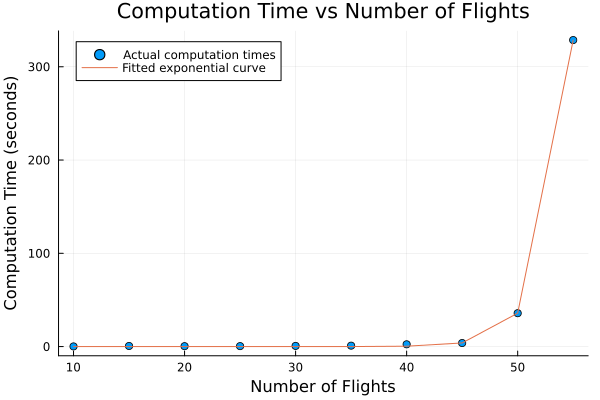

In [10]:
using JuMP, Gurobi, CSV, DataFrames, Plots, LsqFit

num_flights = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
#compute_times = Float64[]  # Initialize empty list to store computation times

# for num_flights in num_flights
#     start_time = time()  # Start timing

#     assign_gates(num_flights,false,false,true)
    
#     # Store computation time for this iteration
#     push!(compute_times, time() - start_time)
#     #println(compute_times)
# end

# Prepare data for plotting
x = num_flights
y = compute_times

# Define exponential model function
exp_model(x, p) = p[1] .* exp.(p[2] .* x)

# Initial parameter guess
p0 = [0.1, 0.01]

# Fit the curve
fit = curve_fit(exp_model, x, y, p0)
fitted_curve = exp_model(x, fit.param)

# Create the plot
plot(x, y, 
     seriestype=:scatter,
     label="Actual computation times",
     xlabel="Number of Flights",
     ylabel="Computation Time (seconds)",
     title="Computation Time vs Number of Flights")

# Extrapolate the computation time for 1000 flights
predicted_time_seconds = exp_model(50, fit.param)
predicted_time_hours = predicted_time_seconds / 60
println("Predicted computation time: $(round(predicted_time_hours, digits=2)) minutes")

# Add fitted exponential curve
plot!(x, fitted_curve, 
      label="Fitted exponential curve",
      line=:solid)

In [9]:
print(compute_times)

[0.18826985359191895, 0.6557071208953857, 0.4470841884613037, 0.5033109188079834, 0.740837812423706, 1.0016429424285889, 2.4462339878082275, 3.8249030113220215, 35.80512499809265, 328.64175486564636]